<a href="https://colab.research.google.com/github/koya-namba/PyTorch_practice/blob/main/MLP%E3%81%AB%E3%82%88%E3%82%8B%E6%89%8B%E6%9B%B8%E3%81%8D%E6%95%B0%E5%AD%97%E3%81%AE%E8%AA%8D%E8%AD%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLPによる手書き数字の認識
多層パーセプトロンを用いて，手書き数字を認識する．

nn.Sequentialを用いることによって，層を積み重ねることができる．

全結合層には，活性化関数はReLUを用いる．

## ライブラリのインポート

torchvisionのdatasetsは，MNISTデータを取り込むために必要なモジュールである．transformsは，

torch.urils.dataのDataLoaderは，ミニバッチのときに必要になる．

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
%matplotlib inline
plt.style.use('ggplot')

## デバイスの確認

gpuを使うことができるか確認．

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## データの前処理



### データのダウンロードと前準備
transforms.ToTensorで，チャネルファーストに変更してくれる．
また，tensor型にも変更をしてくれる．

root='./data'を設定すると，カレントディレクトリの配下にMNISTのデータをダウンロードしてくれる．

そのために，ダウンロードはTrueに設定．トレーニングデータのときは，trainをTrueに設定．

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor()
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### ミニバッチの作成

num_batchesでミニバッチのサイズを決める．

shuffle=Trueに設定することで，毎回異なったミニバッチを作成してくれる．

In [5]:
num_bathes = 100

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=num_bathes, shuffle=True)

### データの観察

In [7]:
train_iter = iter(train_dataloader)

In [8]:
imgs, labels = train_iter.next()

画像データは，

サイズ　×　チャネル数　× 横　× 縦

になっているので，画像で見るときは変換が必要．

In [9]:
imgs.size()

torch.Size([100, 1, 28, 28])

In [10]:
img = imgs[0]

In [11]:
img_permute = img.permute(1, 2, 0)

今回は簡単のため，heatmapで図示する．

In [12]:
sns.heatmap(img_permute)

ValueError: ignored

tensorからnumpyへの変更と２次元配列への変換が必要になる．

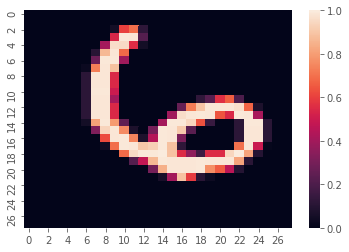

In [14]:
sns.heatmap(img_permute.numpy()[:, :, 0])

In [15]:
labels[0]

tensor(6)

## モデルの構築

ReLUの引数inplace=Trueにすることでメモリの消費を少し抑えることができる．

また，今回の入力は画像サイズの28*28で10クラスの分類問題のため出力は10である．

中間のノードの数は，適当に設定する．

In [27]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28 * 28, 400),
            nn.ReLU(inplace=True),
            nn.Linear(400, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
        )
    def forward(self, x):
        output = self.classifier(x)
        return output

In [28]:
model = MLP()

GPUを使うためにはモデルをGPUに送る必要がある．

In [29]:
model.to(device)

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)

## 学習


### 損失関数と最適化手法

今回は分類問題を扱うので，損失関数はクロスエントロピー誤差を用いる．

最適化手法には，Adamを用いる．

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 学習

ミニバッチごとに損失と精度を計算して，1エポック終わったらその値をリストに加えるようにする．

また，画像に対して，imgs=imgs.view(num_batches, -1)を設定することでバッチの数×それ以外としてデータを入力することができるようになる．

gpuで計算するためには，画像とラベルをgpuに渡すことも忘れずに．

In [31]:
num_epochs = 15
losses = []
accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        imgs = imgs.view(num_bathes, -1)
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)  # CrossEntropyLossの場合は，one_hotの必要がない！
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)  # 確率が最大のラベルを返す．
        running_acc += torch.mean(pred.eq(labels).float())  # floatをつけないといけない
        loss.backward()
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)
    print('epoch: {}, loss: {}, acc: {}'.format(epoch, running_loss, running_acc))

epoch: 0, loss: 0.30431381636609633, acc: 0.9107173681259155
epoch: 1, loss: 0.11073304045014083, acc: 0.9662333130836487
epoch: 2, loss: 0.07345606890584652, acc: 0.9768827557563782
epoch: 3, loss: 0.05195808948056462, acc: 0.9832652807235718
epoch: 4, loss: 0.040954070969989216, acc: 0.986915111541748
epoch: 5, loss: 0.031349408329212264, acc: 0.9901487231254578
epoch: 6, loss: 0.02608377295662649, acc: 0.9915650486946106
epoch: 7, loss: 0.025276673823973396, acc: 0.99224853515625
epoch: 8, loss: 0.018591039570431653, acc: 0.9941653609275818
epoch: 9, loss: 0.017574247475107163, acc: 0.9942482709884644
epoch: 10, loss: 0.016971277219114806, acc: 0.9942151308059692
epoch: 11, loss: 0.010844372421767426, acc: 0.9964986443519592
epoch: 12, loss: 0.014988472446081385, acc: 0.9952653050422668
epoch: 13, loss: 0.010812135955735963, acc: 0.9966155290603638
epoch: 14, loss: 0.012488732980412654, acc: 0.9957153797149658


損失がしっかり下がっており，精度は上がっている．

グラフで確認する．

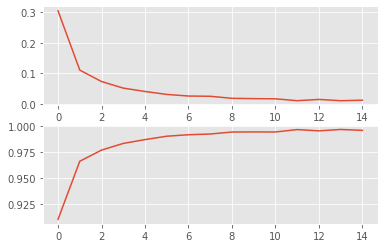

In [32]:
plt.subplot(2, 1, 1)
plt.plot(losses)

plt.subplot(2, 1, 2)
plt.plot(accs)

実際に正しく予測できているのかを確認する．

In [33]:
train_iter = iter(train_dataloader)
imgs, labels = train_iter.next()

In [34]:
labels

tensor([1, 9, 9, 1, 0, 2, 2, 8, 2, 6, 5, 1, 0, 5, 3, 0, 3, 5, 8, 0, 9, 8, 3, 4,
        9, 0, 4, 2, 7, 2, 9, 5, 2, 2, 3, 5, 5, 2, 8, 1, 8, 7, 3, 3, 4, 8, 7, 8,
        5, 1, 9, 8, 0, 4, 6, 4, 1, 3, 3, 1, 8, 4, 2, 5, 2, 0, 9, 2, 5, 3, 2, 8,
        3, 2, 9, 5, 3, 5, 9, 8, 7, 4, 2, 2, 0, 1, 2, 4, 2, 8, 2, 1, 1, 4, 7, 7,
        0, 6, 7, 5])

In [35]:
imgs_gpu = imgs.view(100, -1).to(device)
output = model(imgs_gpu)
pred = torch.argmax(output, dim=1)
pred

tensor([1, 9, 9, 1, 0, 2, 2, 8, 2, 6, 5, 1, 0, 5, 3, 0, 3, 5, 8, 0, 9, 8, 3, 4,
        9, 0, 4, 2, 7, 2, 9, 5, 2, 2, 3, 5, 5, 2, 8, 1, 8, 7, 3, 3, 4, 8, 7, 8,
        5, 1, 9, 8, 0, 4, 6, 4, 1, 3, 3, 1, 8, 4, 2, 5, 2, 0, 9, 2, 5, 3, 2, 8,
        3, 2, 9, 5, 3, 5, 9, 8, 7, 4, 2, 2, 0, 1, 2, 4, 2, 8, 2, 1, 1, 4, 7, 7,
        0, 6, 7, 5], device='cuda:0')

## モデルの保存と取り出し
まずは，モデルの値を取り出す．

In [36]:
params = model.state_dict()

パスを指定して保存

In [37]:
torch.save(params, 'model.prm')

In [38]:
!ls

data  model.prm  sample_data


今度はロードをする．

In [39]:
param_load = torch.load('model.prm')

同じ構造のモデルなら問題なく，当てはめることができる．

In [40]:
model.load_state_dict(param_load)

<All keys matched successfully>

## まとめ

今までの流れをまとめる．

### ライブラリのインポート

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
%matplotlib inline
plt.style.use('ggplot')

### デバイスの確認

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### データの前処理

In [44]:
transform = transforms.Compose([
                                transforms.ToTensor()
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
num_bathes = 100
train_dataloader = DataLoader(train_dataset, batch_size=num_bathes, shuffle=True)

### モデルの構築

In [45]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28 * 28, 400),
            nn.ReLU(inplace=True),
            nn.Linear(400, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
        )
    def forward(self, x):
        output = self.classifier(x)
        return output

### 学習

In [46]:
model = MLP()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [47]:
num_epochs = 15
losses = []
accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        imgs = imgs.view(num_bathes, -1)
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)  # CrossEntropyLossの場合は，one_hotの必要がない！
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)  # 確率が最大のラベルを返す．
        running_acc += torch.mean(pred.eq(labels).float())  # floatをつけないといけない
        loss.backward()
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)
    print('epoch: {}, loss: {}, acc: {}'.format(epoch, running_loss, running_acc))

epoch: 0, loss: 0.3025052256261309, acc: 0.9094341397285461
epoch: 1, loss: 0.10699331085508068, acc: 0.967699408531189
epoch: 2, loss: 0.07254381889787813, acc: 0.9776151776313782
epoch: 3, loss: 0.050499357814357305, acc: 0.9840988516807556
epoch: 4, loss: 0.03714451052384296, acc: 0.9880982637405396
epoch: 5, loss: 0.030031090828900535, acc: 0.990447998046875
epoch: 6, loss: 0.026600321505878433, acc: 0.9912983179092407
epoch: 7, loss: 0.022431916468728257, acc: 0.9924479126930237
epoch: 8, loss: 0.018567941148697475, acc: 0.9942982196807861
epoch: 9, loss: 0.01721752156901251, acc: 0.994398832321167
epoch: 10, loss: 0.015592405666199434, acc: 0.9947819113731384
epoch: 11, loss: 0.012916164785401633, acc: 0.995782196521759
epoch: 12, loss: 0.013491687336797138, acc: 0.9954152703285217
epoch: 13, loss: 0.013264984987032827, acc: 0.9955651164054871
epoch: 14, loss: 0.010517647479673542, acc: 0.9968656897544861


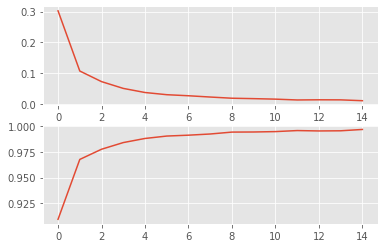

In [48]:
plt.subplot(2, 1, 1)
plt.plot(losses)

plt.subplot(2, 1, 2)
plt.plot(accs)

### モデルの保存

In [49]:
params = model.state_dict()
torch.save(params, 'model.prm')

### モデルを取り出す

In [50]:
param_load = torch.load('model.prm')
model.load_state_dict(param_load)

<All keys matched successfully>